# CSCI E-25      
## Homography and Projection
### Steve Elston

## Introduction   

Transformation or projection of images is a fundamental and essential method in computer vision. Many CV applications, such as image stitching and stereo vision, require projection methods.

In these exercises our primary focus is on projection using the extrinsic matrix. You will apply three types of commonly used extrinsic and one intrinsic transformation to an image:    
1. **Euclidean**, rotation and translation.
2. **Similarity**, rotation, translation and scale.
3. **Affine**,  rotation, translation, scale and shear.    
4. **Projective**, a general transformation for camera pose.   
5. **Intrinsic camera parameters**, focal length.

Before starting the exercises execute the code in the cell below to import the required packages.

In [1]:
import skimage
from skimage import data
from skimage.filters.rank import equalize
import skimage.filters as skfilters
import skimage.morphology as morphology
import skimage.transform as transform
from skimage.color import rgb2gray
from skimage import exposure
from skimage.draw import circle_perimeter, polygon_perimeter
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Prepare the Image

For these exercises you will work with a gray scale image. Execute the code in the cell below to load the image and display it.

Image size = (512, 512)


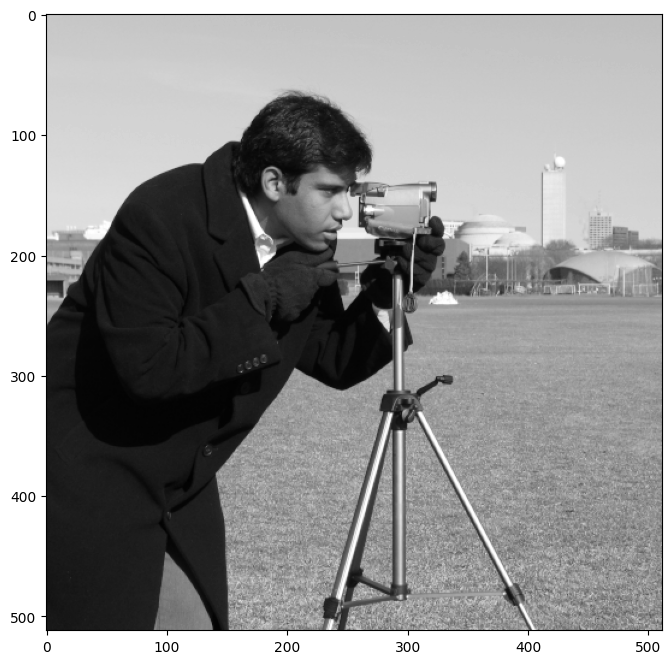

In [2]:
def plot_grayscale(img, h=8, ax=None):
    if ax is None:
        plt.figure(figsize=(h, h))
        _=plt.imshow(img, cmap=plt.get_cmap('gray'))
    else:
         _=ax_i.imshow(img, cmap=plt.get_cmap('gray'))

camera_image = data.camera()
print('Image size = ' + str(camera_image.shape))
plot_grayscale(camera_image)

To make the process of visualizing the transformations of image easier a dark margin will be added to the image. Execute the code in the cell below to place the image on the background and to display the result.   

Shape of the background = (1024, 1024)


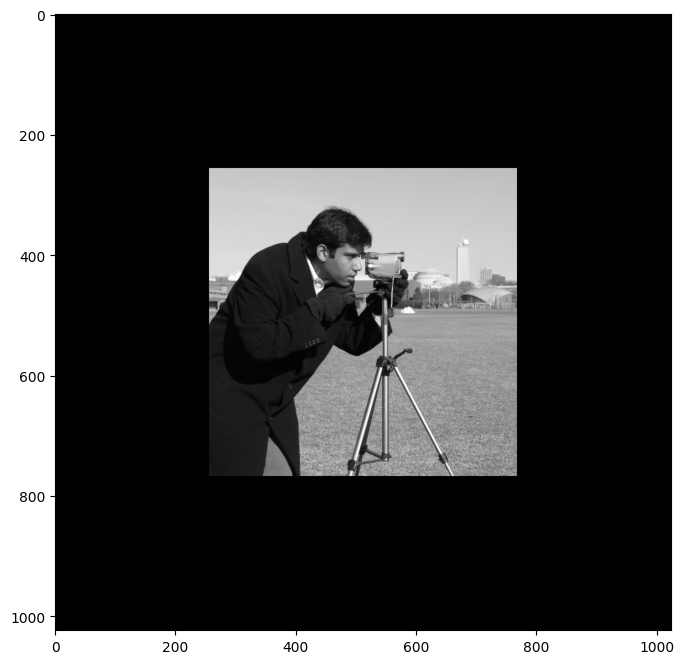

In [3]:
half_margin = 256
background = np.zeros((camera_image.shape[0] + 2*half_margin, camera_image.shape[1] + 2*half_margin)).astype('int')
print('Shape of the background = ' + str(background.shape))

camera_image_background = background
#camera_image_background[2*half_margin:camera_image_background.shape[0], 0:camera_image_background.shape[1]-2*half_margin] = camera_image
camera_image_background[half_margin:camera_image_background.shape[0] - half_margin, half_margin:camera_image_background.shape[1]-half_margin] = camera_image
plot_grayscale(camera_image_background)

> **Note:** Unless otherwise specified, use this gray scale image of the photographer where specified in the following exercises.

To demonstrate these principles execute the code in the cell below to create an image with some simple geometric shapes.

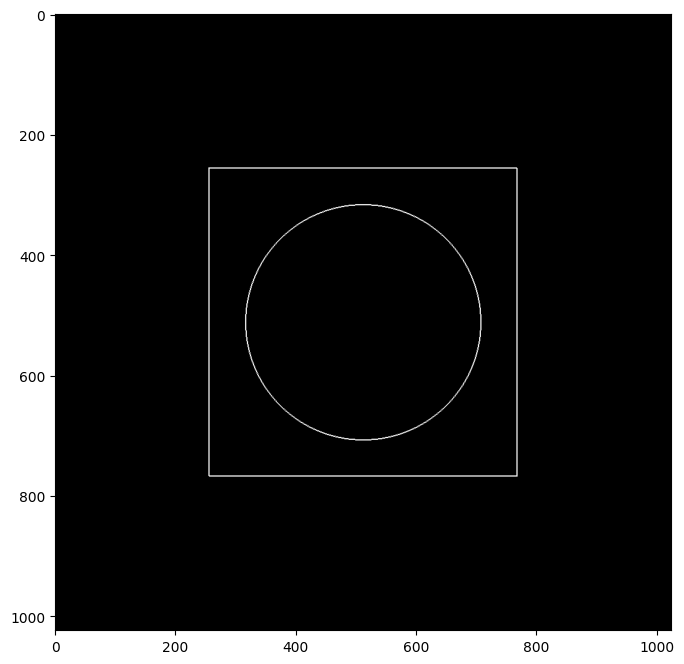

In [6]:
## Create a blank image
synthetic_image = np.zeros((1024, 1024), dtype=np.uint8)\
## Add a circle
rr, cc = circle_perimeter(512, 512, 196)
synthetic_image[rr, cc] = 1
rr, cc = circle_perimeter(512, 512, 195)
synthetic_image[rr, cc] = 1
## Add a square
rr, cc = polygon_perimeter([256, 256, 768, 768], [256, 768, 768, 256])
synthetic_image[rr, cc] = 1
rr, cc = polygon_perimeter([255, 255, 767, 767], [255, 767, 767, 255])
synthetic_image[rr, cc] = 1
## Display the results
plot_grayscale(synthetic_image)

## Euclidean Transformation

The Euclidean transformation involves only rotation and translation. The shape of objects is preserved by the Euclidean transformation.    

The code in the cell below applies both translation and rotation to the geometric shape image. The Execute this code and examine the results.  

> **Exercise 9-1:** You will now apply the Euclidean transformation to the synthetic image and then the real image. This operation involves applying a rotation and translation to the image plane. Follow the numbered steps.
> 1. To start, you will complete the function in the cell below. The function will return a $3 x 3$ Numpy array for the Euclidean transform.

In [7]:
def euclidean(theta, translation):
    ## Put your code below
    ans = np.array([[np.cos(theta), -np.sin(theta), translation[0]],
                    [np.sin(theta), np.cos(theta), translation[1]],
                    [0, 0, 1]])
    return ans




> 2. Execute the code in the cell below.
>
> **Important Note:** Notice that the second argument of the warp functuion is an *inverse map*. This convention makes sense for many CV tasks, such as image stitching and stereo vision, where one must apply the inverse transform to an image to recify it with the coordinates of a reference image. This means that some values of transform matrix will need to be modified to account for the way the transformaiton in applied by this function. Which transformation variables using an inverse affects depends on which side of the image plane the observer is viewing. For these exercises, we assome the observer is looking at the image plane from the side with the images in the scene. We maintain the right-handed coordinate system convention from this point of view.     

[[  0.981   0.195 -99.886]
 [ -0.195   0.981  99.886]
 [  0.      0.      1.   ]]
[[   0.924   -0.383  195.934]
 [   0.383    0.924 -195.934]
 [   0.       0.       1.   ]]


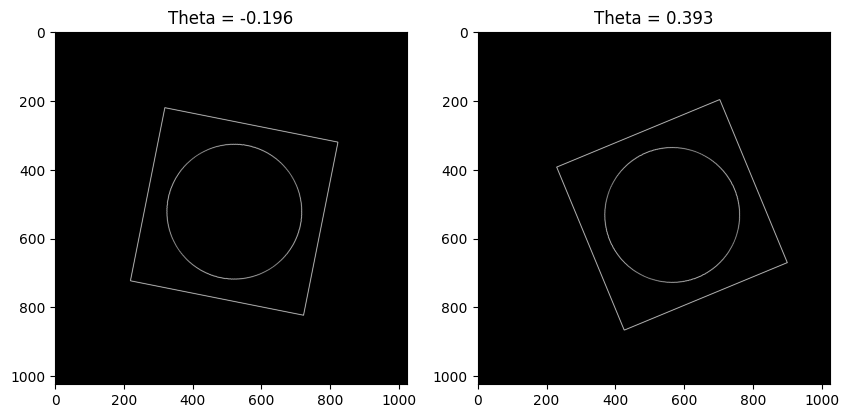

In [8]:
n_pix = 512.0
_, ax = plt.subplots(1,2, figsize=(10, 5))
ax = ax.flatten()
theta = [-math.pi/16.0, math.pi/8.0]
for i,ax_i in enumerate(ax):
    translation = np.array([n_pix * math.sin(theta[i]), -n_pix * math.sin(theta[i])])

    transform_matrix = euclidean(theta[i], translation)
    print(np.round(transform_matrix, 3))
    _=plot_grayscale(transform.warp(synthetic_image, transform_matrix), ax=ax_i)
    ax_i.set_title('Theta = ' + str(np.round(theta[i], 3)))

> Answer the following questions:    
> Q1. Does the roation angle appear correct for both case and why given the right-handed coordinate system?     
> Q2. Which aspect? of the rectangle shape are preseved by this transform? In other words, why is the Euclidean transformation consider ridgid body motion.             
> Q3. Explain why the x and y translations computed above keep shapes at the center of the images in the right-handed coordinate system. Pay attention to the sign of the translation compoenents, keeping in mind the origin of the coordiate system is at the upper left of the image.        

> **Answers:**     
> Q1.  Yes the rotations make sense with the right handed coordinate system since the rotation is happening in the xy plane and positive theta moves from the postiive x axis rotating towards the positive y axis in a counter clockwise direction.
> Q2. The lines in the shape are preserved in this transform because each line has an equal translation theta and their space in respect to each other is maintained.    
> Q3. Since the rotation happens  not at the center of the image, but a corner, the translation moves the image the required distance to make up for movement about the corner. Also, the translation vector moves the image in the positive x, but negative y, which puts the image relatively centered since the origin was top left.    

> 3. Apply the second transformation matrix to the image of the photographer and display the result.  

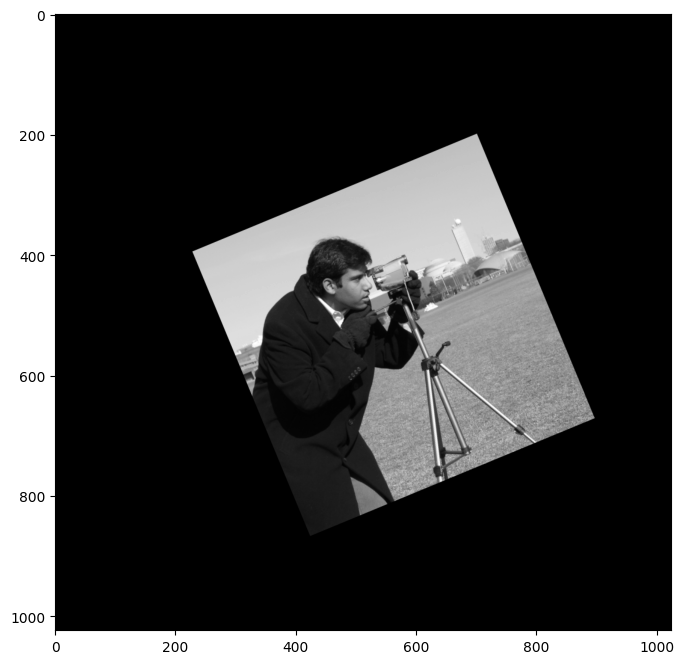

In [9]:
_=plot_grayscale(transform.warp(camera_image_background, transform_matrix))

> Q4. Is the transformation of the photographer image consistent with the transformation of the geometric shape image and is this expected?     

> **Answer:**   Yes, the transformation is as expected since for similar reasons above. The photographer is merely a more complex image.   

> 4. Finally, you can check your transformation matrix by using the [skimage.transform.EuclideanTransform](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.EuclideanTransform) function, using the rotation angle and translation vector for the second example. Compute and display the transformation matrix.   

[[   0.924   -0.383  195.934]
 [   0.383    0.924 -195.934]
 [   0.       0.       1.   ]]


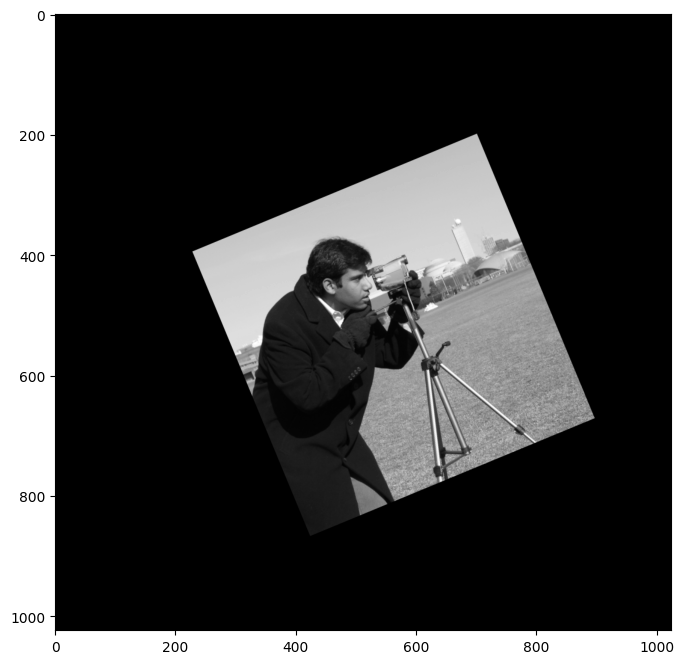

In [10]:
## Put your code below
transform_matrix = transform.EuclideanTransform(rotation = theta[1], translation = translation)
print(np.round(transform_matrix, 3))
_=plot_grayscale(transform.warp(camera_image_background, transform_matrix))



> Q5. Compare the transformation matrix comptued with the function you created with the one created with the Scikit image functuion. Are they identical as is this expected?    
> **End of exercise.**

> **Answer:**  Yes they are    

## Similarity Transform

You will now extend the generality of the transformation by adding a change of scale. A similarity transformation can perform rotation, translation as well as scale. Like the Euclidean transform, the similarity transform parallel lines and angles.   

> **Exercise 9-2:**  You will now do the following to explore the properties of the similarity transform:
> 1. Complete the `similarity`function in the cell below to compute and return the following.      
>    a. Use the `euclidean` function you created in Exercise 1 to compute the $3 x 3$ Euclidiean transformation matrix.       
>    b. Create a $3 x 3$ scale transform as a Numpy array with the **inverse** x axis and y axis scale factors as the first two diagonal elements, 1.0 as the final diagonal element, and 0s everywhere else. The inverse of the scale is required since the [skimage.transform.warp](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.warp) function expects the inverse.
>    c. Use [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) function to multiply the Euclidean matrix (second argument) by the scale matrix (first argument). The order of the multiplication will mater.
> 2. Execute the code.

[[   0.924   -0.765    0.   ]
 [   0.383    1.848 -256.   ]
 [   0.       0.       1.   ]]
[[   1.848   -0.383    0.   ]
 [   0.765    0.924 -256.   ]
 [   0.       0.       1.   ]]


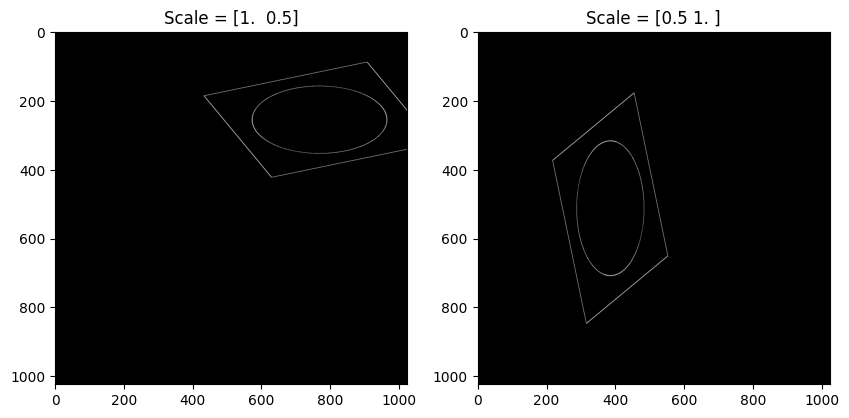

In [11]:
## Put your code below
def similarity(theta, translation, scale):
    ## Complete the function
    # Use the euclidean function you created in Exercise 1 to compute the  3𝑥3  Euclidiean transformation matrix.
    transform_matrix = euclidean(theta, translation)
    # Create a  3𝑥3  scale transform as a Numpy array with the inverse x axis and y axis scale factors as the first
    # two diagonal elements, 1.0 as the final diagonal element, and 0s everywhere else. The inverse of the scale is
    #required since the skimage.transform.warp function expects the inverse. c. Use numpy.dot function to multiply
    # the Euclidean matrix (second argument) by the scale matrix (first argument). The order of the multiplication will mater.
    scale_matrix = np.array([[1/scale[0], 0, 0],
                             [0, 1/scale[1], 0],
                             [0, 0, 1.0]])
    return np.dot(transform_matrix, scale_matrix)



_, ax = plt.subplots(1,2, figsize=(10, 5))
ax = ax.flatten()
theta = math.pi/8.0
scale = np.array([[1.0,0.5],
                 [0.5, 1.0]])
for i,ax_i in enumerate(ax):
    transform_matrix = similarity(theta, [0, -256], scale[i,:])
    print(np.round(transform_matrix,3))
    _=plot_grayscale(transform.warp(synthetic_image, transform_matrix), ax=ax_i)
    ax_i.set_title('Scale = ' + str(np.round(scale[i,:], 3)))

> Now, answer the following questions:     
> Q1: Notice the x and y axis scaling of the geometric shapes. Are the images as expected given the two scalings and why?    
> Q2: What properties of the rectangle are preseved by these transformations?      
> Q3: Noice that y translation has changed for the first case. How can you expalain this change, keeping in mind that we are computing the inverse transform?     

> **Answers:**     
> Q1: Yes they are as expected except for the translations. The scalings seems to be relative to the former images, though the translations seem to require scaling as well.    
> Q2: The shape and positioning seem to stay intact axis wise, but stretching does happen in the opposing axis due to the scales being different.     
> Q3: It appears the translation was altered by the scale the y axis had applied.     

> 4. Apply the second transformation matrix to the image of the photographer and display the result.  

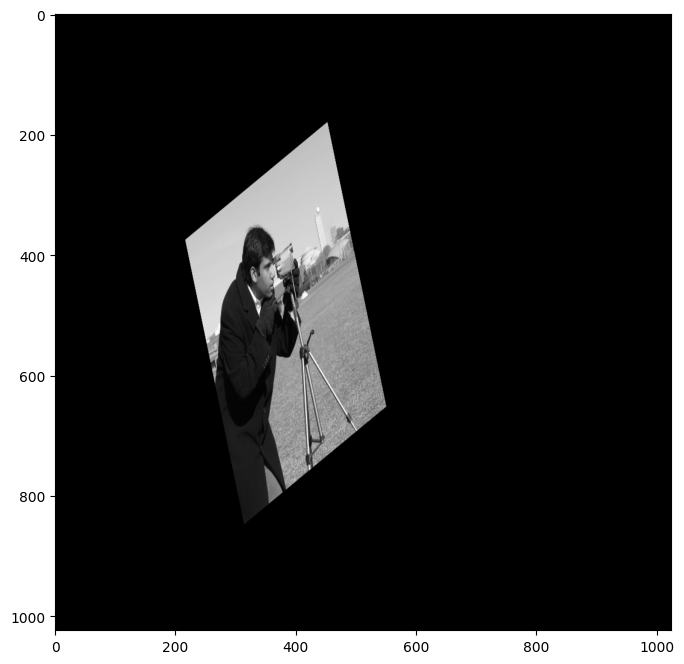

In [12]:
_=plot_grayscale(transform.warp(camera_image_background, transform_matrix))

> Q4. Is the transformation of the photograper image consistent with the geometric image and is this expected?      

> **Answer:**    This transorm is consistent with the shape image and is expected.

> 4. You can check your transformation matrix by using the [skimage.transform.SimilarityTransform](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.SimilarityTransform) function, using the rotation angle, translation vector and scale (using the inverse). Compute and display the transformation matrix, in homogeneous coordinates, using the arguments specified for the second transformation.  Given the inverse convention of the `warp` function you will need to use the inverse scaling which you can compute with [numpy.divide](https://numpy.org/doc/stable/reference/generated/numpy.divide.html).     

[[   1.848   -0.383  195.934]
 [   0.765    0.924 -195.934]
 [   0.       0.       1.   ]]


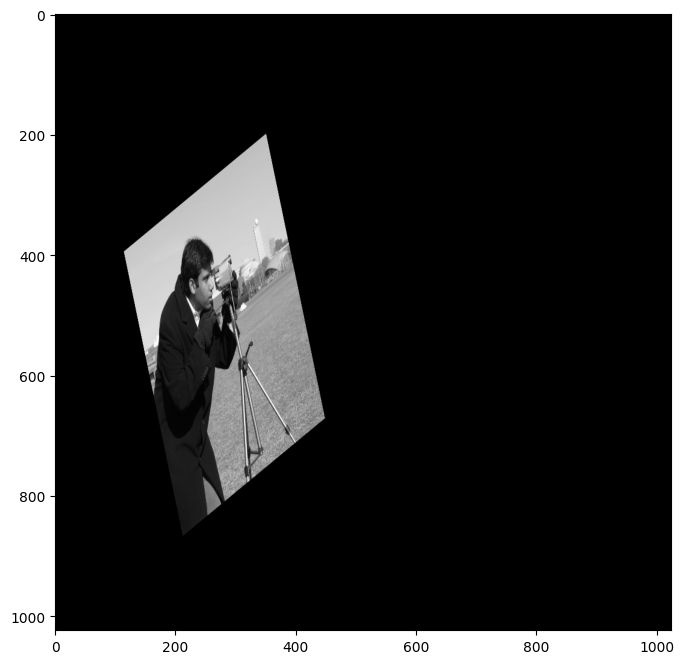

In [13]:
## Put your code below
transform_matrix = transform.SimilarityTransform(rotation = theta, translation = translation, scale = 1/scale[1,:])
print(np.round(transform_matrix, 3))
_=plot_grayscale(transform.warp(camera_image_background, transform_matrix))


>  Q5. Is the homogeneous transformation matrix you computed identical to the one computed with your similarity transform function, with the permutation of some off-diagonal values becasuse of the use of the inverse convention?      
> **End of exercise.**

> **Answer:**  Yes, the diagonal values are identical, some of the off diagonals are skewed.   

> **Exercise 9-3:** One can use negative scaling with a similarity transform to create flipped images about an axis, e.g. mirror images. This appraoch can be quite useful in creating augmented datasets, and can be combined with rotaion, scaling, etc. to create additonal training examples. You will now complete the code in the cell below to display three cases:
> 1. Flip around the vertical axis with no rotation and maintaining scale.
> 2. Flip around the horizontal axis with no rotation and maintaining scale.
> 3. Flip around both axes with no rotation and maintaining scale.      

[[-1.000e+00  0.000e+00 -1.024e+03]
 [ 0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00]]
[[ 1.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00 -1.000e+00 -1.024e+03]
 [ 0.000e+00  0.000e+00  1.000e+00]]
[[-1.000e+00  0.000e+00 -1.024e+03]
 [ 0.000e+00 -1.000e+00 -1.024e+03]
 [ 0.000e+00  0.000e+00  1.000e+00]]


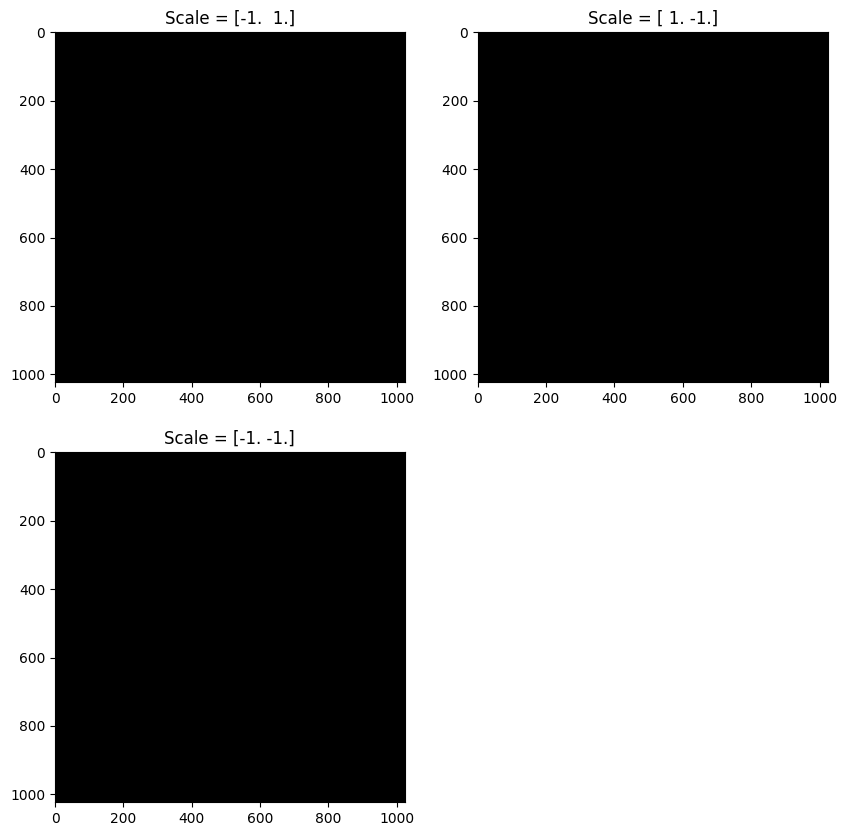

In [34]:
translate = np.array([[-1024, 0],[0, -1024],[-1024, -1024]])
## Complete the code required to create mirror image
# Flip around the vertical axis with no rotation and maintaining scale.
# Flip around the horizontal axis with no rotation and maintaining scale.
# Flip around both axes with no rotation and maintaining scale.
scale = np.array([[-1.0,1.0],
                  [1.0,-1.0],
                  [-1.0,-1.0]])


_, ax = plt.subplots(2,2, figsize=(10, 10))
ax = ax.flatten()
ax[-1].set_visible(False)
for i, ax_i in enumerate(ax[:-1]):
    transform_matrix = similarity(0.0, translate[i,:], scale[i,:])
    print(np.round(transform_matrix,3))
    _=plot_grayscale(transform.warp(camera_image_background, transform_matrix), ax=ax_i)
    ax[i].set_title('Scale = ' + str(np.round(scale[i,:], 3)))

> **End of Exercise**

## Affine Transform

Continuing to generalize the transformation you will now add a shear factor to the transformation. An affine transformation can perform rotation, translation, scaling and shear. The affine transformation preserves parallel lines.   

> **Exercise 9-4:**  You will now do the following to explore the properties of the affine transform following these steps
> 1. Complete the `affine`function in the cell below to compute and return the following.      
>    a. Use the `similarity` function you created in Exercise 2 to compute the $3 x 3$ similarity transformation matrix.       
>    b. Create a $3 x 3$ shear transform as a Numpy array with $tan(\gamma)$ on the first two off-diagonal elements.
>    c. Use [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) function to multiply the similarity matrix (second argument) by the shear matrix (first argument). The order of the multiplication will mater.
> 2. Execute the code in the cell below.    

[[   2.    0. -400.]
 [   2.    2. -800.]
 [   0.    0.    1.]]
[[   2.    2. -800.]
 [   0.    2. -400.]
 [   0.    0.    1.]]


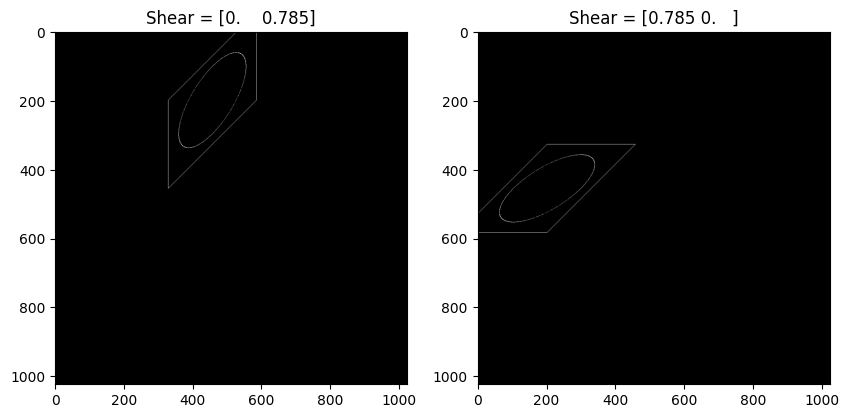

In [19]:
## Put your code below
def affine(theta, translation, scale, shear):
    ## Complete the function
    similarity_matrix = similarity(theta, translation, scale)
    shear_matrix = np.array([[1,math.tan(shear[0]), 0],
                             [math.tan(shear[1]), 1, 0],
                             [0,0,1]])
    transform_matrix = np.dot(shear_matrix, similarity_matrix)
    return transform_matrix


theta = 0.0
scale = [0.5,0.5]
translation = [-400,-400]

_, ax = plt.subplots(1,2, figsize=(10, 5))
ax = ax.flatten()
shear = np.array([[0.0, math.pi/4], [math.pi/4, 0.0]])
for i,ax_i in enumerate(ax):
    transform_matrix = affine(theta, translation, scale, shear[i,:])
    print(np.round(transform_matrix,3))
    _=plot_grayscale(transform.warp(synthetic_image, transform_matrix), ax=ax_i)
    ax_i.set_title('Shear = ' + str(np.round(shear[i,:], 3)))

> Examine these results and anser the following questions.     
> Q1. Examine the shear applied to rectangle. Are the shapes as expected from the shear applied and why?     
> Q2. What properties of the rectangle have been preserved by these transformations?      

> **Answers:**      
> Q1.  Yes they are as expected, The first image is sheared in respect to y, and the second is sheared in respect to x. Both show the parallel lines in those axis were maintained, but the perpendicular acis saw some skewing.  
> Q2.  As stated above, the parallel lines in respect to the axis being sheared were maintained.    

> 3. Apply the second affine transform matrix to the photograph of the photographer and display the result.   

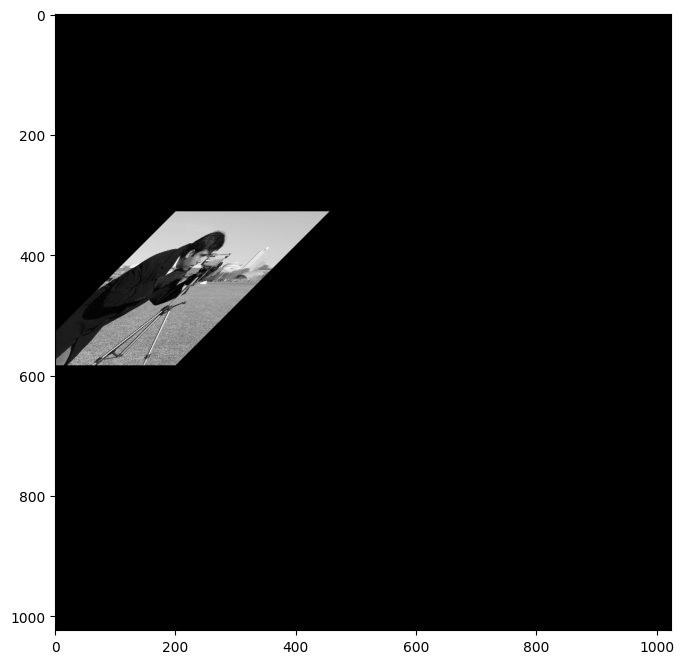

In [20]:
_=plot_grayscale(transform.warp(camera_image_background, transform_matrix))

> **End of Exercise**

## Working with the Intrinsic Matrix

Up until now, you have been working only with the **extrinsic transformation matrix**, which defines the projection from one plan onto another plane, with the same camera center. The extrinsic properties of are also known as **camera pose**. These transformations do not account for inernal camera parameters.   

The **intrinsic matrix** is used to model camera specific characteristics. Here we will only deal with one camera parameter, the focal length. Focal length is typically denoted $[f_x, f_y]$, for the x and y components, which can be independent. The differences in x and y can arrise for a number of reasons, such as asymmetry of the camera sensor.     

It is often easier to work with the inverse of focal length:     

$$\Bigg[\frac{1}{f_x},\frac{1}{f_x} \Bigg] = [\phi_x, \phi_y]$$    

In Cartesian coordinates, for a basic pinhole camera the object location, $[x,y,w]$, maps to the $[x,y]$ location on the image plane by the following relationships:   

$$[x,y] = \Bigg[\frac{u}{f_x\ w},\frac{v}{f_x\ w} \Bigg]= \Bigg[\frac{\phi_x\ u}{w},\frac{\phi_y\ v}{w} \Bigg]$$


> **Exercise 9-5:** You will now apply an intrinsic matrix for two different camera focal lengths by the following steps:  
> 1. Define a Numpy intrinsic matrix in homogeneous coordinates with focal length $[f_x, f_y]=[0.5, 0.5]$, array offset of 0, and skew correction of 0.      
> 2. Define a Numpy extrinsic transform matrix in homogeneous coordinates using the `affine` function you created in Exercise 3 with rotation $\theta= 0$, translation $= [-512,-512]$, scaling $=[1.0,1.0]$, and shear $[0.0,0.0]$.  
> 3. Perform matrix multiplication between the extrinsic matrix (first argument) by the intrinsic matrix (second argument) using [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html).
> 4. Print the resulting product of the transformation matrices.
> 5. Apply the resulting transformation product to the image of the photographer and display the result.

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]
[[   1.    0. -512.]
 [   0.    1. -512.]
 [   0.    0.    1.]]
[[   2.    0. -512.]
 [   0.    2. -512.]
 [   0.    0.    1.]]


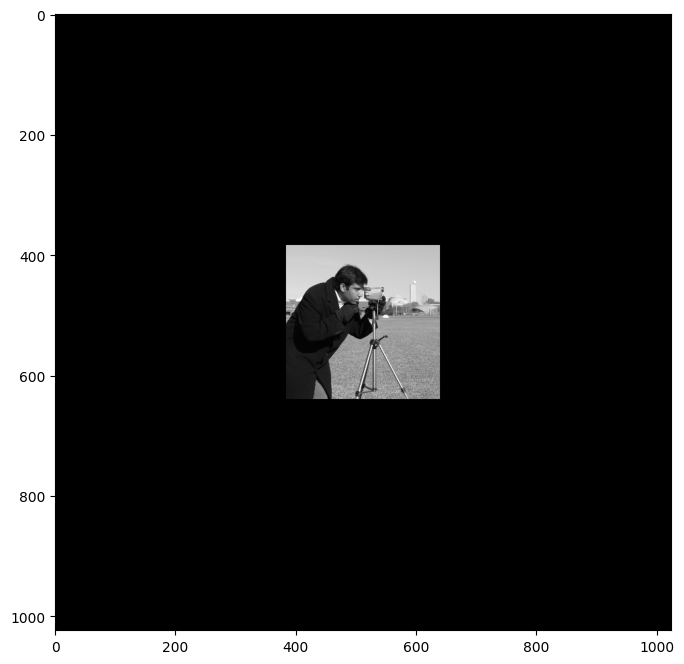

In [24]:
## Put your code below
# Define a Numpy intrinsic matrix in homogeneous coordinates with focal length
# [𝑓𝑥,𝑓𝑦]=[0.5,0.5] , array offset of 0, and skew correction of 0.
intrinsic_matrix = np.array([[1/0.5,0,0],
                             [0,1/0.5,0],
                             [0,0,1]])
print(intrinsic_matrix)
# Define a Numpy extrinsic transform matrix in homogeneous coordinates using the
# affine function you created in Exercise 3 with rotation  𝜃=0 , translation  =[−512,−512] ,
#  scaling  =[1.0,1.0] , and shear  [0.0,0.0] .
extrinsic_matrix = affine(0, [-512,-512], [1,1], [0,0])
print(extrinsic_matrix)

# Perform matrix multiplication between the extrinsic matrix (first argument) by the intrinsic
#  matrix (second argument) using numpy.dot.
transformed_matrix = np.dot(extrinsic_matrix, intrinsic_matrix)

# Print the resulting product of the transformation matrices.
print(transformed_matrix)

# Apply the resulting transformation product to the image of the photographer and
# display the result.
_=plot_grayscale(transform.warp(camera_image_background, transformed_matrix))








> 6. Define a Numpy intrinsic matrix in homogeneous coordinates with focal length $[f_x, f_y]=[2.0, 2.0]$, array offset of 0, and skew correction of 0.     
> 7. Define a Numpy extrinsic transform matrix in homogeneous coordinates using the `affine` function you created in Exercise 3 with rotation $\theta= 0$, translation $= [256,256]$, scaling $=[1.0,1.0]$, and shear $[0.0,0.0]$.  
> 8. Perform matrix multiplication between the extrinsic matrix (first argument) by the intrinsic matrix (second argument) using [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html).
> 9. Print the resulting product of the transformation matrices.
> 10. Apply the resulting transformation product to the image of the photographer and display the result.

[[0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]
[[  1.   0. 256.]
 [  0.   1. 256.]
 [  0.   0.   1.]]
[[  0.5   0.  256. ]
 [  0.    0.5 256. ]
 [  0.    0.    1. ]]


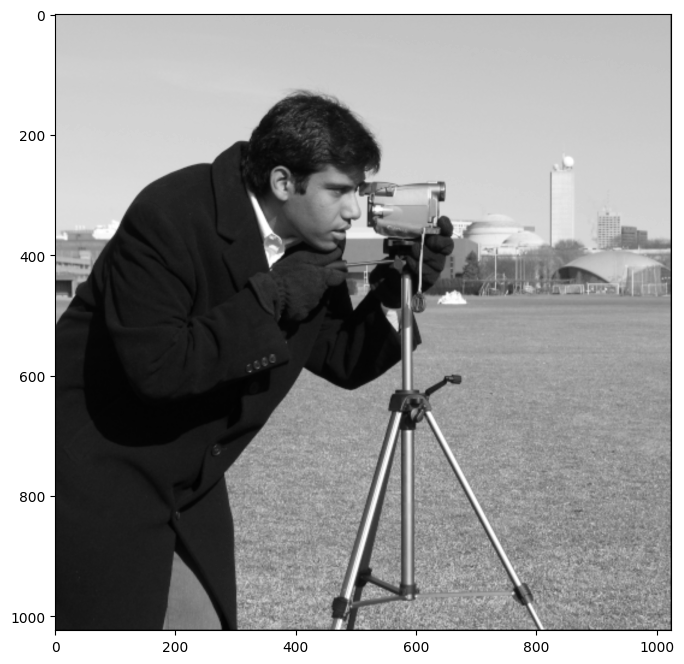

In [25]:
## Put your code below
# Define a Numpy intrinsic matrix in homogeneous coordinates with focal length
# [𝑓𝑥,𝑓𝑦]=[2.0,2.0] , array offset of 0, and skew correction of 0.
intrinsic_matrix = np.array([[1/2.0,0,0],
                             [0,1/2.0,0],
                             [0,0,1]])
print(intrinsic_matrix)
# Define a Numpy extrinsic transform matrix in homogeneous coordinates using the
# affine function you created in Exercise 3 with rotation  𝜃=0 , translation  =[256,256] ,
#  scaling  =[1.0,1.0] , and shear  [0.0,0.0] .
extrinsic_matrix = affine(0, [256,256], [1.0,1.0], [0.0,0.0])
print(extrinsic_matrix)
# Perform matrix multiplication between the extrinsic matrix (first argument) by
# the intrinsic matrix (second argument) using numpy.dot.
transformed_matrix = np.dot(extrinsic_matrix, intrinsic_matrix)
# Print the resulting product of the transformation matrices.
print(transformed_matrix)
# Apply the resulting transformation product to the image of the photographer and display the result.
_=plot_grayscale(transform.warp(camera_image_background, transformed_matrix))





> In one or two sentences expain the relationship you observe between focal length and field of view on the image plane and how do you think this effect relates to wide angle and telephoto camera lenses?       
> **End of exercise**.

> **Answer:**  The smaller focal length allowed us to see the entire image, but at a more distantant view (smaller iamge, scaled down). But the larger focal length gave the appearance of a zoom, scaling the image but losing some of the field of view.  

## Projective transform

All of the transforms we have worked on so far require the optical center to be at the same location. In other words, the perspective point is unchanged. Projective transforms are the most general planar transformations. Here we will only deal with some simple examples, which are equivalent to changing the camera position or perspective point. This transformation or homography, $mathcal{H}$, can be expressed:    

$$\mathcal{H} = H_P H_A H_S H_E$$    
Where,        
$H_E =$ the Euclidean transform matrix.      
$H_S =$ the similarity transform matrix.    
$H_A =$ the affine transform matrix.    

And,     
$H_P = \begin{bmatrix}
   1  & 0 & 0 \\
    0  & 1 & 0 \\
    \phi_{31}  & \phi_{32} & 1
\end{bmatrix}$

We will call the last row, $[\phi_{31}, \phi_{32}, 1]$, the perspective vector

For the following exercise you will work with a picture of a piece of furniture in the interior of a house. To load and prepare this image execute the code in the cell below.  

Iinital image shape = (3024, 4032, 3)
Final image shape = (300, 400)


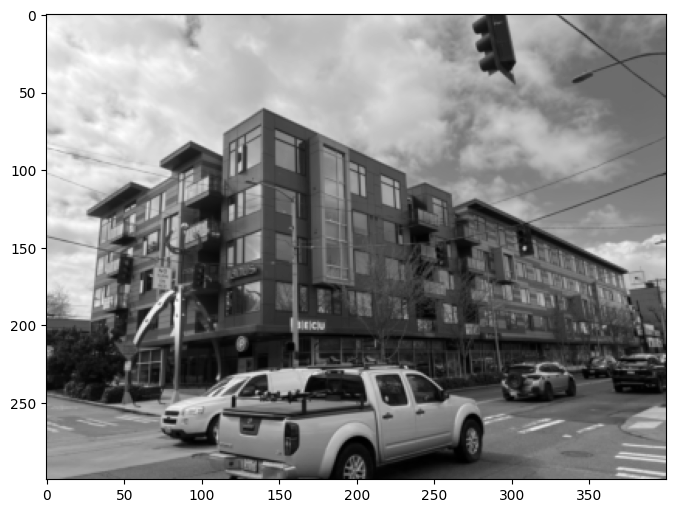

In [31]:
# updated path due to using colab
building = Image.open('/content/Building4.jpg')
building = np.array(building)
print('Iinital image shape = ' + str(building.shape))

building = rgb2gray(building)
building = transform.resize(building, (300,400))
print('Final image shape = ' + str(building.shape))

plot_grayscale(building)

> **Exercise 9-6:**  You will now do the following to explore the properties of the projective transform or homography following these steps
> 1. Complete the `projective`function in the cell below to compute and return the following.      
>    a. Use the `affine` function you created in Exercise 4 to compute the $3 x 3$ affine transformation matrix.       
>    b. Create a $3 x 3$ projective transform Numpy array with 1s on the diagonal and zeros elsewhere for the first two rows. The third row should be the `perspective ` argument of the function, the perspective vector.
>    c. Use [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) function to multiply the affine matrix (second argument) by the perspective matrix (first argument). The order of the multiplication will mater.
> 2. Execute the code in the cell below.    

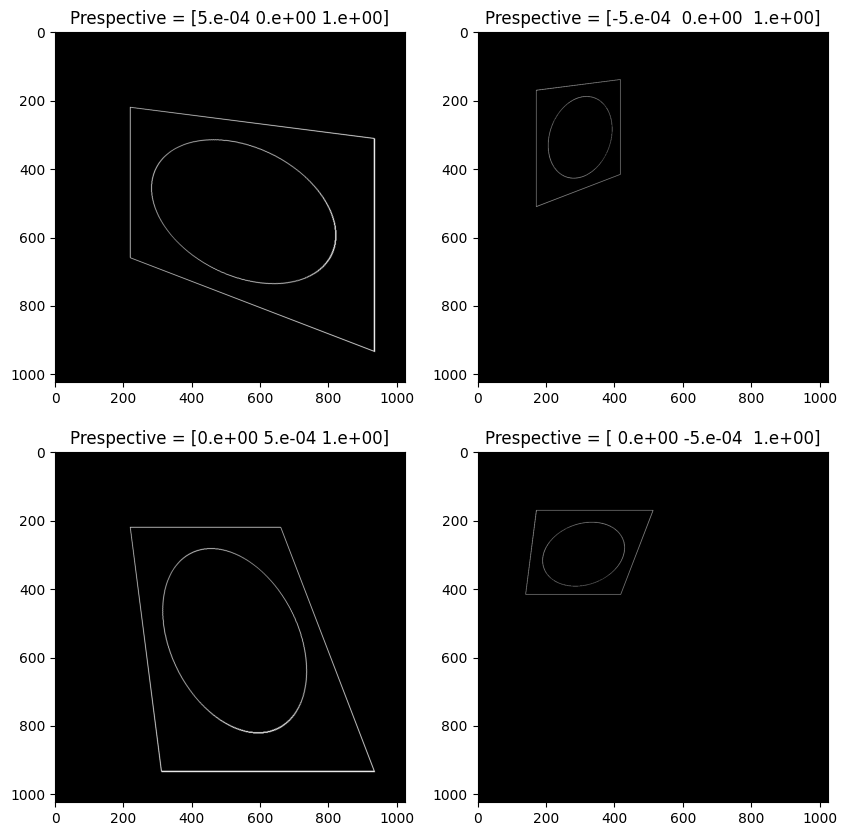

In [32]:
def projective(theta, translation, scale, shear, perspective):
    ## Complete the code in this function
    # a. Use the affine function you created in Exercise 4 to compute the  3𝑥3  affine
    #  transformation matrix.
    affine_matrix = affine(theta, translation, scale, shear)
    # b. Create a  3𝑥3  projective transform Numpy array with 1s on the diagonal and
    # zeros elsewhere for the first two rows. The third row should be the perspective
    # argument of the function, the perspective vector. c. Use numpy.dot function to
    # multiply the affine matrix (second argument) by the perspective matrix (first argument).
    #The order of the multiplication will mater.
    projective_matrix = np.array([[1,0,0],
                                  [0,1,0],
                                  perspective])
    return np.dot(projective_matrix, affine_matrix)



shear = [0.0, 0.0]
theta = 0.0
scale = [.75, .75]
translation = [0.0,0.0]

_, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()
perspective = np.array([[0.0005, 0, 1.0],
                      [-0.0005, 0, 1.0],
                      [0, 0.0005, 1.0],
                      [0, -0.0005, 1.0]])
for i,ax_i in enumerate(ax):
    transform_matrix = projective(theta, translation, scale, shear, perspective[i,:])
    _=plot_grayscale(transform.warp(synthetic_image, transform_matrix), ax=ax)
    ax_i.set_title('Prespective = ' + str(perspective[i,:]))

> Examine the transformed images of the geometric shapes. The original geometric image has the perspective point on a line perpendicular to the center point. Describe the perspective point for each image in terms of change of perspective point. An answer in simple relative terms with respect to the original perspective point, right, left, up, down, and distance (nearer, further) are all that is required. Hint: The keystone shape tapers away from the perspective point.      

> **Answers by perspective vector:**      
> $[0.0005, 0, 1.0]$   Left nearer
> $[-0.0005, 0, 1.0]$  Right further  
> $[0, 0.0005, 1.0]$    Up nearer
> $0, -0.0005, 1.0]$    Down further

> 3. Next execute the code in the cell below to apply the perspective transform to the building image.   

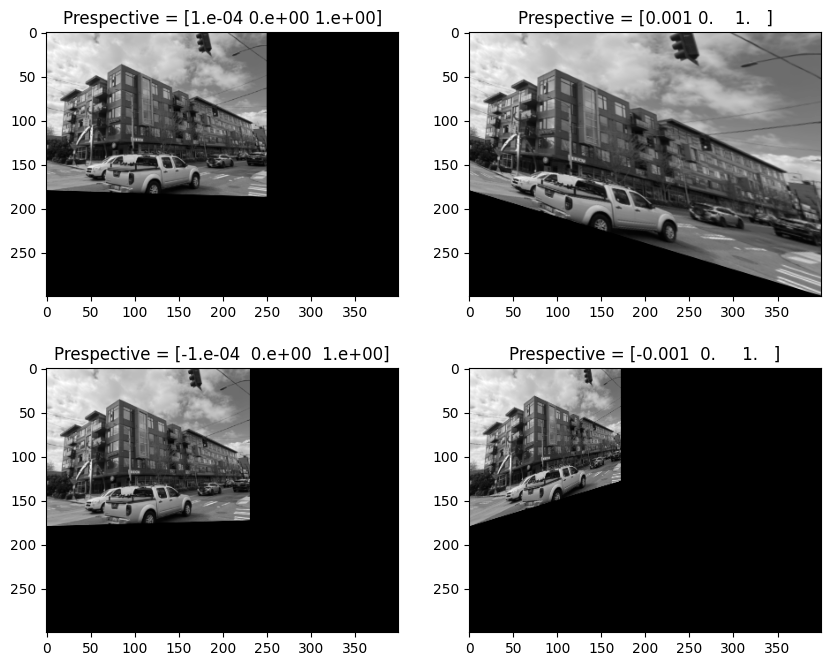

In [33]:
shear = [0.0, 0.0]
theta = 0.0
scale = [.6, .6]
translation = [0.0,0.0]

_, ax = plt.subplots(2,2, figsize=(10,8))
ax = ax.flatten()
perspective = np.array([[0.0001, 0, 1.0],
                        [0.001, 0, 1.0],
                        [-0.0001, 0, 1.0],
                      [-0.001, 0.0, 1.0]])
for i,ax_i in enumerate(ax):
    transform_matrix = projective(theta, translation, scale, shear, perspective[i,:])
    _=plot_grayscale(transform.warp(building, transform_matrix), ax=ax)
    ax_i.set_title('Prespective = ' + str(perspective[i,:]))

> Examine the transformed images of the building image. Describe the change of perspective point for each transformed image in terms of change of perspective point. An answer in simple relative terms with respect to the original perspective point, right, left, up, down, and distance (nearer, further) are all that is required.    
> **End of Exercise.**

> **Answers by perspective vector:**      
> $[0.0001, 0, 1.0]$  further        
> $[0.001, 0, 1.0]$   left nearer   
> $[[-0.0001, 0, 1.0]$  further          
> $[-0.001, 0.0, 1.0]$  right further  

####  Copyright 2022, 2023, 2024 Stephen F Elston. All rights reserved.